####   Required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

#### Set this according to datasets path

In [2]:
curr_path = os.getcwd()
dataset_path = os.path.join(curr_path,'datasets')
datasets = os.listdir(dataset_path)
train_set_path = os.path.join(dataset_path,datasets[1])
test_set_path = os.path.join(dataset_path,datasets[0])

#### Reading of csv files

In [3]:
train_set = pd.read_csv(train_set_path)
test_set = pd.read_csv(test_set_path)

In [4]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to 28x28
dtypes: int64(785)
memory usage: 359.3 MB


In [5]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 785 entries, label to 28x28
dtypes: int64(785)
memory usage: 59.9 MB


#### Preparing the training , validation and test set

In [6]:
train_set = np.array(train_set)
np.random.shuffle(train_set)
test_set = np.array(test_set)

In [7]:
train_set_X = train_set[:,1:]
train_set_y = train_set[:,0].reshape(-1,1)
test_set_X = test_set[:,1:]
test_set_y = test_set[:,0].reshape(-1,1)

In [8]:
train_set_images = train_set_X.reshape(-1,28,28)
test_set_images = test_set_X.reshape(-1,28,28)
train_set_labels = train_set_y
test_set_labels = test_set_y

Label : [2]


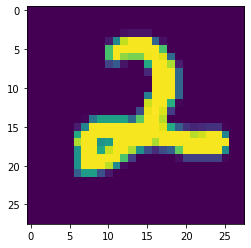

In [9]:
plt.imshow(train_set_images[0])
print("Label :",train_set_labels[0])

In [10]:
X = train_set_X[:50000,:].T
X_val = train_set_X[50000:,:].T
y = train_set_y[:50000,:]
y_val = train_set_y[50000:,:]

#### Scaling down the features

In [11]:
X = X/256
X_val = X_val/256

In [12]:
np.set_printoptions(threshold=np.inf)

#### Adding layer dimensions

In [13]:
n_features = X.shape[0]
m = X.shape[1]
n_h = 10
n_y = 10
layers = 4
layer_units = [n_features]
for i in range(1,layers):
    layer_units.append(n_h*(layers-i+1)) 
layer_units.append(n_y)

In [14]:
print(n_features)
print(m)
print(layer_units)

784
50000
[784, 40, 30, 20, 10]


#### Function for converting y to onehot

In [15]:
def convert_to_onehot(n_y,m,y):
    y_onehot = np.zeros((n_y,m))
    for i in range(m):
        y_onehot[y[i,0],i] = 1
    
    return y_onehot

#### Function to calculate loss

In [16]:
def cross_entropy_loss(a,y):
    return -np.sum(np.log(a)*y)/a.shape[1]

#### Function for Initializing parameters

In [17]:
def initialize_parameters(layers,layer_units):
    parameters = {}
    for i in range(1,layers+1):
        parameters['W'+str(i)] = np.random.randn(layer_units[i-1],layer_units[i])*np.tanh(np.sqrt(1/(layer_units[i-1])))
        parameters['b'+str(i)] = np.zeros((layer_units[i],1))
    return parameters

#### Relu function

In [18]:
def relu_forward(z):
    return np.maximum(0,z)

#### Softmax function

In [19]:
def softmax_forward(z):
    output_layer = np.exp(z)/np.sum(np.exp(z),axis=0,keepdims=True)
    return output_layer

#### Forward Propagation

In [20]:
def forward_propagation(X,parameters,layers):
    cache = {}
    cache['Z1'] = np.dot(parameters['W1'].T,X) + parameters['b1']
    for i in range(1,layers):
        cache['A'+str(i)] = relu_forward(cache['Z'+str(i)])

        cache['Z'+str(i+1)] = np.dot(parameters['W'+str(i+1)].T,cache['A'+str(i)]) + parameters['b'+str(i+1)]
    cache['A'+str(layers)] = softmax_forward(cache['Z'+str(layers)])
    return cache

#### Relu Backward

In [21]:
def relu_backward(dA,Z):
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
    return dZ

#### Softmax Backward

In [22]:
def softmax_backward(Y,A):
    return -(Y-A)

#### Backward Propagation

In [23]:
def backward_propagation(cache,parameters,X,Y,layers):
    gradients = {}
    gradients['dZ'+str(layers)] = softmax_backward(Y,cache['A'+str(layers)])
    for i in reversed(range(1,layers)):
        gradients['dW'+str(i+1)] = np.dot(gradients['dZ'+str(i+1)],cache['A'+str(i)].T).T
        gradients['db'+str(i+1)] = np.sum(gradients['dZ'+str(i+1)]*parameters['b'+str(i+1)],axis=1,keepdims=True)
        gradients['dA'+str(i)] = np.dot(parameters['W'+str(i+1)],gradients['dZ'+str(i+1)])
        gradients['dZ'+str(i)] = relu_backward(gradients['dA'+str(i)],cache['Z'+str(i)])
    gradients['dW1'] = np.dot(gradients['dZ1'],X.T).T
    gradients['db1'] = np.sum(gradients['dZ1']*parameters['b1'],axis=1,keepdims=True)
    return gradients

#### Updating parameters

In [24]:
def update_parameters(parameters,gradients,learning_rate):
    for i in range(1,layers+1):
        parameters['W'+str(i)] = parameters['W'+str(i)] - learning_rate*gradients['dW'+str(i)]
        parameters['b'+str(i)] = parameters['b'+str(i)] - learning_rate*gradients['db'+str(i)]
    return parameters

#### Execution Flow

In [25]:
parameters = initialize_parameters(layers,layer_units)

In [26]:
y_onehot = convert_to_onehot(n_y,m,y)
y_onehot_val = convert_to_onehot(n_y,10000,y_val)

In [27]:
cache = forward_propagation(X,parameters,layers)
cache_val = forward_propagation(X_val,parameters,layers)

In [28]:
cross_entropy_loss(cache['A'+str(layers)],y_onehot)

2.3185299117019436

In [29]:
learning_rates = [0.000007,0.000005,0.000004,0.000004]
costs = []
costs_val = []
for i in range(1300):
    cost = cross_entropy_loss(cache['A'+str(layers)],y_onehot)
    cost_val = cross_entropy_loss(cache_val['A'+str(layers)],y_onehot_val)
    gradients = backward_propagation(cache,parameters,X,y_onehot,layers)
    parameters = update_parameters(parameters,gradients,learning_rates[int(i/400)])
    cache = forward_propagation(X,parameters,layers)
    cache_val = forward_propagation(X_val,parameters,layers)
    if((i+1)%50 == 0):
        costs.append(cost)
        costs_val.append(cost_val)
        print("Iteration",i+1,": train_loss :",cost,", val_loss :",cost_val)

Iteration 50 : train_loss : 1.0555124623115337 , val_loss : 1.0364269353950093
Iteration 100 : train_loss : 0.40729739398192794 , val_loss : 0.4065514569706054
Iteration 150 : train_loss : 0.291410480135405 , val_loss : 0.30194611008144207
Iteration 200 : train_loss : 0.23078966138519116 , val_loss : 0.2404012656277945
Iteration 250 : train_loss : 0.19458215594260106 , val_loss : 0.20546225254219153
Iteration 300 : train_loss : 0.17189088513890405 , val_loss : 0.1841739480516403
Iteration 350 : train_loss : 0.1581992327551499 , val_loss : 0.17144613096513173
Iteration 400 : train_loss : 0.14051835148678346 , val_loss : 0.15598341982217154
Iteration 450 : train_loss : 0.1311933004819902 , val_loss : 0.14850034040048443
Iteration 500 : train_loss : 0.12332093218804407 , val_loss : 0.14245988474986213
Iteration 550 : train_loss : 0.11653390870040774 , val_loss : 0.13750430076497175
Iteration 600 : train_loss : 0.11054063431895567 , val_loss : 0.13315025044575268
Iteration 650 : train_loss

#### Predicting Outputs and Calculating Accuracy

In [30]:
pred_labels = cache['A'+str(layers)].argmax(axis=0)
pred_labels_val = cache_val['A'+str(layers)].argmax(axis=0)
orig_y = np.squeeze(y)
orig_y_val = np.squeeze(y_val)

In [31]:
train_count = 0
for i in range(50000):
    if(pred_labels[i] == orig_y[i]):
        train_count+=1

val_count = 0
for i in range(10000):
    if(pred_labels_val[i] == orig_y_val[i]):
        val_count+=1
        
train_accuracy = (train_count*100)/50000
val_accuracy = (val_count*100)/10000

print("Model accuracy on training set is "+str(train_accuracy)+"%")
print("Model accuracy on validation set is "+str(val_accuracy)+"%")

Model accuracy on training set is 98.126%
Model accuracy on validation set is 97.06%


In [32]:
X_test = test_set_X.T
y_test = test_set_y
X_test = X_test/256
orig_y_test = np.squeeze(y_test)
cache_test = forward_propagation(X_test,parameters,layers)
pred_labels_test = cache_test['A'+str(layers)].argmax(axis=0)

In [33]:
test_count = 0
for i in range(10000):
    if(pred_labels_test[i] == orig_y_test[i]):
        test_count+=1

test_accuracy = (test_count*100)/10000
print("Model accuracy on test set is "+str(test_accuracy)+"%")

Model accuracy on test set is 96.47%
